# 

In [1]:
%load_ext autoreload
%autoreload 2

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from problems import Knapsack

from circuit_lengths import add_lengths_to_df
from regressor import fit_multi

import matplotlib.colors as mco

import quantum_plots as qp
_ = qp.global_setup()

In [3]:
df = pd.read_feather("../../results/qpe_main.feather")

In [4]:
df = df[df.qaoa != "kickback_cost"]

In [5]:
df["method"] = df.qaoa + df["ancilla"].transform(lambda x: "" if np.isnan(x) else "_" + str(int(x)))

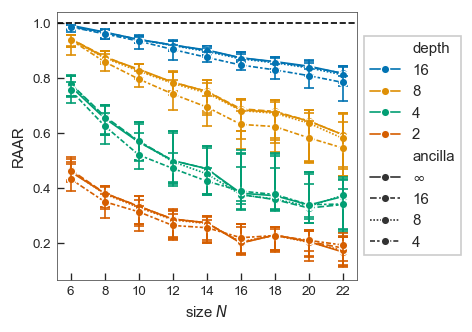

In [334]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

methods = ["qpe_4", "qpe_8", "qpe_16", "masked_cost"]

dfx = df.query("method in @methods and depth >= 2").copy()
dfx["ancilla"] = dfx.ancilla.transform(lambda x: r"$\infty$" if np.isnan(x) else str(int(x)))
    
l = sns.lineplot(
    dfx, 
    x="n_qubits",
    y="rnd_approx_ratio",
    hue="depth",
    style="ancilla",
    hue_order=[16, 8, 4, 2],
    style_order=[r"$\infty$", "16", "8", "4"],
    legend=True,
    estimator=np.median,
    err_style="bars",
    err_kws={"capsize": 3},
    errorbar=("pi", 50),
    marker="o",
    markersize=5,
    palette="colorblind",
)

plt.axhline(y=1, c="k", ls="--")

sns.move_legend(l, loc="center left", bbox_to_anchor=(1, 0.5))

plt.xlabel("size $N$")
plt.ylabel("RAAR")

plt.xticks(range(6, 24, 2), range(6, 24, 2));

#.sns.stripplot(df.query("depth == 8"), x="n_qubits", y="rnd_approx_ratio", hue="method", dodge=True, alpha=0.1, legend=False, marker='.', palette="dark", jitter=False)

# plt.yscale("log")

plt.savefig("plots/qpe_raar.pdf", bbox_inches="tight", transparent=True)

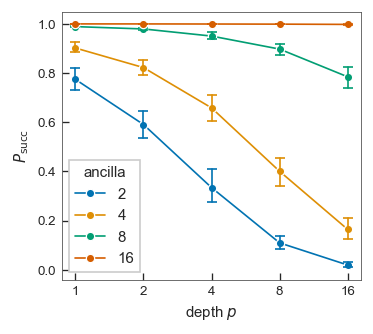

In [99]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)

df["1mp"] = 1 - df.p_succ

dfx = df.query("qaoa == 'qpe'").copy()
dfx.ancilla = dfx.ancilla.astype(int)

sns.lineplot(
    dfx, 
    x="depth",
    y="p_succ",
    hue="ancilla",
    # style="n_qubits",
    legend=True,
    estimator=np.median,
    errorbar=("pi", 50),
    err_style="bars",
    err_kws={"capsize": 3},
    marker="o",
    markersize=5,
    palette="colorblind"
)
#plt.yscale("log")
plt.xscale("log")

plt.ylabel(r"$P_{\mathrm{succ}}$")
plt.xlabel("depth $p$")

plt.xticks([1, 2, 4, 8, 16], [1, 2, 4, 8, 16])

plt.savefig("plots/qpe_psucc.pdf", bbox_inches="tight", transparent=True)

In [59]:
df.query("depth == 1").p_succ.describe()

count    2304.000000
mean        0.916352
std         0.096604
min         0.602619
25%         0.864179
50%         0.972344
75%         0.995217
max         0.999987
Name: p_succ, dtype: float64

In [121]:
add_lengths_to_df(df, Knapsack)

In [123]:
df.clops.max()

2128.0

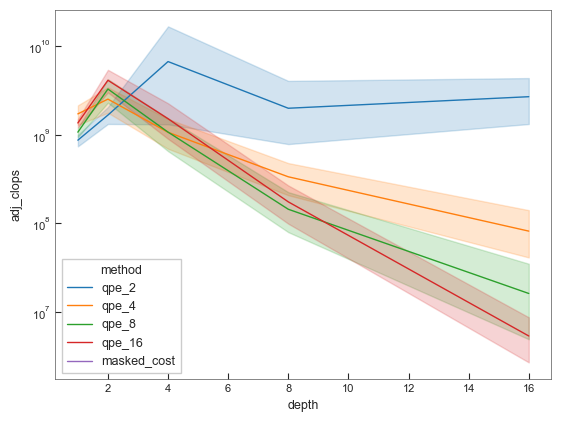

In [109]:
df["adj_clops"] = df.clops * np.ceil(np.log(0.01) / np.log(1 - df.p_opt * df.p_succ))
sns.lineplot(df.query("n_qubits == 22"), x="depth", y="adj_clops", hue="method")
plt.yscale("log")

In [101]:
df["log_adj_clops"] = np.log(df.adj_clops)

df_fit = fit_multi(df.query("qaoa == 'qpe'"), x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

df_fit

slope  intercept    rvalue     lower     upper
method depth                                                   
qpe_16 1      0.712027   5.132122  0.964882  0.700891  0.723163
       2      0.743706   4.657261  0.880411  0.721235  0.766176
       4      0.671042   4.389322  0.807755  0.644204  0.697879
       8      0.517660   5.105816  0.822984  0.497978  0.537342
       16     0.342953   6.502480  0.808929  0.329289  0.356618
qpe_2  1      0.738593   4.245878  0.949125  0.724575  0.752612
       2      0.726981   4.464407  0.911429  0.708402  0.745559
       4      0.698382   4.649870  0.862078  0.675481  0.721282
       8      0.562113   6.662911  0.811727  0.539919  0.584306
       16     0.472260   9.439418  0.630130  0.442598  0.501921
qpe_4  1      0.760071   4.084806  0.948035  0.745482  0.774659
       2      0.755610   4.093132  0.882960  0.733057  0.778163
       4      0.706498   3.840556  0.866358  0.683750  0.729246
       8      0.570317   5.084356  0.838420  0.549792  0.590843
       16     0.418164   7.312109  0.720541  0.396815  0.439514
qpe_8  1      0.739901   4.384328  0.967347  0.728757  0.751046
       2      0.764007   3.994523  0.878697  0.740736  0.787279
       4      0.694635   3.731546  0.822694  0.668198  0.721072
       8      0.543297   4.540112  0.838478  0.523749  0.562846
       16     0.371528   6.127603  0.794070  0.356017  0.387038

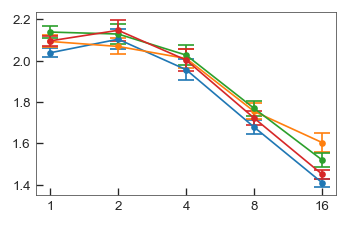

In [103]:
qp.plot_setup()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

In [178]:
df2 = pd.read_feather("../../results/qpe_scaling.feather")
df2["method"] = df2.qaoa + df2["ancilla"].transform(lambda x: "" if np.isnan(x) else "_" + str(int(x)))

In [179]:
add_lengths_to_df(df2, Knapsack)

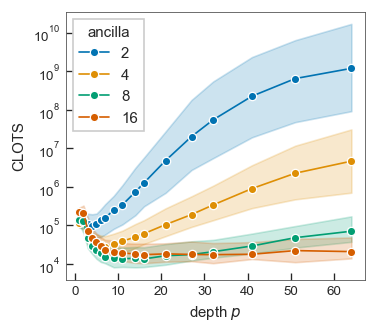

In [337]:
qp.plot_setup(aspect_ratio=0.9)

df2["p_tot"] = df2.p_succ.fillna(1) * df2.p_opt
df2["reps"] =  np.ceil(np.log(0.01) / np.log(1 - df2.p_tot))
df2["adj_clops"] = df2.reps * df2.clops
df2["1mp"] = 1 - df2.p_opt

df2["ancilla"] = df2["ancilla"].transform(lambda x: 0 if np.isnan(x) else int(x))
sns.lineplot(df2.query("n_qubits == 10 and ancilla > 0"), x="depth", y="adj_clops", hue="ancilla", palette="colorblind", estimator=np.median, marker="o", markersize=5, errorbar=("pi", 50))
plt.yscale("log")

plt.xlabel("depth $p$")
plt.ylabel("CLOTS")

plt.savefig("plots/qpe_clots.pdf", bbox_inches="tight", transparent=True)

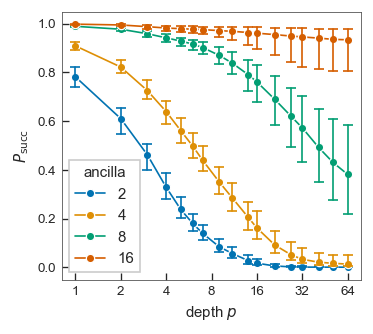

In [333]:
fig, _ = qp.plot_setup(aspect_ratio=0.9)


sns.lineplot(
    df2.query("ancilla > 0"), 
    x="depth",
    y="p_succ",
    hue="ancilla",
    # style="n_qubits",
    legend=True,
    estimator=np.median,
    errorbar=("pi", 50),
    err_style="bars",
    err_kws={"capsize": 3},
    marker="o",
    markersize=5,
    palette="colorblind"
)

plt.xscale("log")

plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)])
plt.xlabel("depth $p$")
plt.ylabel("$P_\mathrm{succ}$")

plt.savefig("plots/qpe_psucc.pdf", bbox_inches="tight", transparent=True)

In [161]:
df2["log_adj_clops"] = np.log10(df2["adj_clops"])

df_fit = fit_multi(df2.query("qaoa == 'qpe'"), x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

([<matplotlib.axis.XTick at 0x28ce87ee0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(16, 0, '16'),
  Text(32, 0, '32'),
  Text(64, 0, '64')])

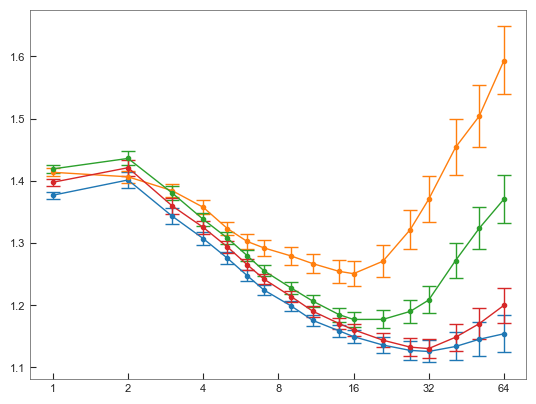

In [173]:
dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(x.depth, np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
plt.xscale("log")
plt.xticks([1 << i for i in range(7)], [1 << i for i in range(7)])
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")

In [308]:
from fastqaoa.ctypes.qpe_qaoa import qpe_qaoa
from fastqaoa.ctypes.qaoa import qaoa

from fastqaoa.indicator import get_indicator_interpolator, interpolate_diagonals
from fastqaoa.ctypes.metrics import Metrics

In [197]:
interp = get_indicator_interpolator(8, 4, 0.6)

ks = Knapsack.get_instances()[6][0]

In [293]:
dfd = df2.query("qaoa == 'masked_cost' and n_qubits == 6")

interps = {
    2: get_indicator_interpolator(2, 4, 0.6),
    4: get_indicator_interpolator(4, 4, 0.6),
    8: get_indicator_interpolator(6, 4, 0.6),
    16: get_indicator_interpolator(6, 4, 0.6)
}

In [317]:
def func(x):
    res = []
    prb = Knapsack.get_instances()[x.n_qubits][x.problem_id]
    cost, weights = prb.diagonalized()
    masked_cost = prb.masked_cost()

    cost = cost / np.abs(masked_cost.min_val) * cost.n_qubits

    constr_org = weights.scale_between_sym()

    data = dict(x).copy()
    data["qaoa"] = "masked_cost"
    data["initial"] = "from_exact"
    mc = masked_cost / np.abs(masked_cost.min_val) * masked_cost.n_qubits
    sv = qaoa(mc, x.betas, x.gammas)
    
    new_data = Metrics.compute(sv, masked_cost, weights).dump()
    res.append(data)
    
    
    for i, interp in interps.items():
        constr = interpolate_diagonals(interp, constr_org)
        sv, psucc = qpe_qaoa(cost, constr, x.betas, x.gammas)
    
        new_data = Metrics.compute(sv, masked_cost, weights).dump()
    
        data = dict(x).copy()
        data["qaoa"] = "qpe"
        data["ancilla"] = i
        data["initial"] = "from_exact"
        data["p_succ"] = psucc
        data["shift"] = 0.6
        data.update(new_data)
    
        res.append(data)

    prb.decache()

    return pd.DataFrame(res)

x = dfd.apply(func, axis=1)
df3 = pd.concat(list(x))
add_lengths_to_df(df3, Knapsack)

### Why is paramter transfer so bad?